<p style="text-align: center;">  PRINCIPAL COMPONENT ANALYSIS OF GLOBAL SOCIOECONOMIC INDICATORS </p>

<p style="text-align: center;"> Daniel Losada </p>
<p style="text-align: center;"> Gabriel Pons </p>
<p style="text-align: center;"> Raúl Rodríguez </p>

<p style="text-align: center;"> November 2024 </p>
<p style="text-align: center;"> Multivariate Analysis </p>

**INDEX**

[0. Abstract](#0-abstract)

[1. Input data](#1-input-data)

[2. Exploratory Data Analysis (EDA)](#2-eda)

- [2.1 Correlation Matrix](#21-correlation-matrixcorrel)

- [2.2 Pair plot](#22-pairplot)

- [2.3 Intercorrelation coefficients](#23-intercorrelation-coefficients)

 - [2.4 Data visualization](#24-data-visualization)

 - [2.5 Data transformation ](#25-data-transformation)

-  [2.6 Principal Component Analysis (PCA)](#26-principal-component-analysis-pca)

[3. References](#3-references)

# 0. Abstract

This study examines the relationships between socioeconomic and commercial variables across all countries. Initially, the dataset is preprocessed to handle missing values, standardize scales, and ensure data quality. A preliminary analysis of the raw data is performed to explore basic patterns and correlations. Then, to enhance interpretability and reduce dimensionality, a Principal Component Analysis (PCA) is applied. This approach identifies the principal factors driving variability in the dataset, facilitating a deeper understanding of complex relationships among variables. The findings provide information about global socioeconomic and commercial trends, highlighting key dimensions that characterize the raw data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Input data

Our study is based on a huge dataset with data collected from almost all countries in the world. Some variables are not in this dataset from Kaggle, so we have implemented them to complete the compulsory rules about this project.
The idea is to analyze some socio-economic variables that allow us to have an overview about relations between these variables and its behaviour in each country (observation). To do so we have chosen from Kaggle the following variables: 

-	`child_mort`: death of children under 5 years per 1000 live births (continuous)

-	`exports`: Exports of goods and services per capita as % of the GDP per capita (continuous)

-	`health`: Health spending per capita as % of GDP per capita (continuous)

-	`imports`: Imports of goods and services as % of the GDP per capita (continuous)

-	`income`: Net income per person (continuous)

-	`inflation`: Inflation as a measurement of the annual growth rate of the total GDP (continuous)

-	`life_expec`: Average number of years a newborn child would live if the current mortality patterns are to remain the same (continuous)

-	`total_fer`: number of children that would be born to each woman if the current age-fertility rates remain the same (continuous)

-	`gdpp`: GDP per capita (continuous)

Then we added new variables:

-	`idh`: Human development index, calculated from some measures of welfare, and belonging to the $(0,1)$ interval, being 1 the best conditions to live and 0 the worst. (continuous but adapted to be binary)

- `regime_type`: showing how their model of government is (categorical) accompained of a continuous variable (index_2023) that clasify numerically the regime type, but we are not going to take it into account.

-	`continent`: What continent does each country belong to (categorical)

-	`coast`: if it has a coast or not (binary)

The data of `idh` is taken from [Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index#List). The index is published every year by the UNDP.

The data of `regime_type` is taken from [Wikipedia](https://en.wikipedia.org/wiki/The_Economist_Democracy_Index#List_by_country). From a list made by The Economist. We took the last data available, from 2023.

The data of `continent` and `coast` was generated by Chat GPT and then corrected by us.


We merged all the data by 'country' considering an inner join to obtain only full observations. To make this decision, first we developed the function `check_match` to see how many countries would be left out during the merge. We compared the merge by pairs of the different sources to detect mistakes in the matching. Some countries had it's name written in a different way, so we had to manually standardize them.

In [2]:
def check_match(df1, df2, key):
    # Perform an outer join and identify non-matching entries
    df_merged = pd.merge(df1, df2, on=key, how='outer', indicator=True)

    # Filter rows that don't have matches in either dataframe
    non_matching_ids = df_merged[df_merged['_merge'] != 'both']

    # Display non-matching rows
    print(non_matching_ids[['country', '_merge']])

In [3]:
# Set the seed for reproducibility
seed = 42

# Load the CSV files
df_country = pd.read_csv('Country-data.csv')
df_idh = pd.read_csv('idh.csv')
df_democracy = pd.read_csv('democracy.csv')
df_continent_coast = pd.read_csv('countries_continent_coast.csv')

print("# countries in Country-data: ", len(df_country))
print("# countries in idh: ", len(df_idh))
print("# countries in democracy: ", len(df_democracy))
print("# countries in continent_coast: ", len(df_continent_coast))

df = pd.merge(df_country, df_idh, on='country')
df = pd.merge(df, df_democracy, on='country')
df = pd.merge(df, df_continent_coast, on='country')

#display(df)
print("# countries in the final dataframe: ", len(df))


# countries in Country-data:  167
# countries in idh:  193
# countries in democracy:  167
# countries in continent_coast:  167
# countries in the final dataframe:  152


As we need another binary variable we've transformed the `idh` into a binary variable. If the `idh` is above the median, then the country is developed. Otherwise, it is not.

We've also removen the variable `index_2023`, which explained the type of regime based on a continous coefficent. Since it contributes with the same information as type of regime, we've deleted it. 

In [4]:
median_idh = df['idh'].median()
print("Median IDH: ", median_idh)

df['binary_idh'] = df['idh'] > median_idh

#Drop unnecessary columns
#df.drop(columns=['idh', 'index_2023', 'country'], inplace=True)
df.drop(columns=['idh', 'index_2023'], inplace=True)

binary_columns = ['binary_idh', 'coast']
multiclass_columns = ['continent', 'regime_type']
quantitative_columns = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

Median IDH:  0.7444999999999999


# 2. EDA

## 2.1. Correlation matrix

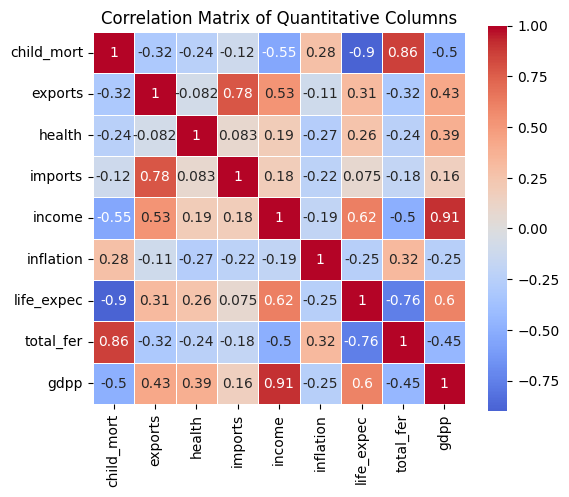

In [5]:
# Calculate the correlation matrix for the quantitative columns
correlation_matrix = df[quantitative_columns].corr()

plt.figure(figsize=(6, 5))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, linewidths=.5)

# Display the plot
plt.title("Correlation Matrix of Quantitative Columns")
plt.show()


Notice that the correlation between a variable itself is 1 (diagonal) and the matrix is symmetric since $r_{jk}=r_{kj}$
What we are measuring is the linear relation between quantitative variables. Every entry in the matrix is a pairwise coefficient of correlation. This coefficient can take values between $-1$ and $1$ being positive values positive linear relation. The nearer is a value to $|1|$ the stronger is the linear relation.
Notice that most of the relations are strong enough to star with the test. We have some weaker values as the relation between exports and inflation or between imports and life expectancy, but there are lots of them near or over $|0.5|$ showing the existence of linear relation between pairs.

As the purpose is applying the PCA technique, we need that some of the quantitative variables are correlated so that we can combine them to obtain the components and reduce the dimensionality. With the calculated correlation matrix, we can appreciate that most of the variables have enough level of correlation. 

## 2.2. Pairplot

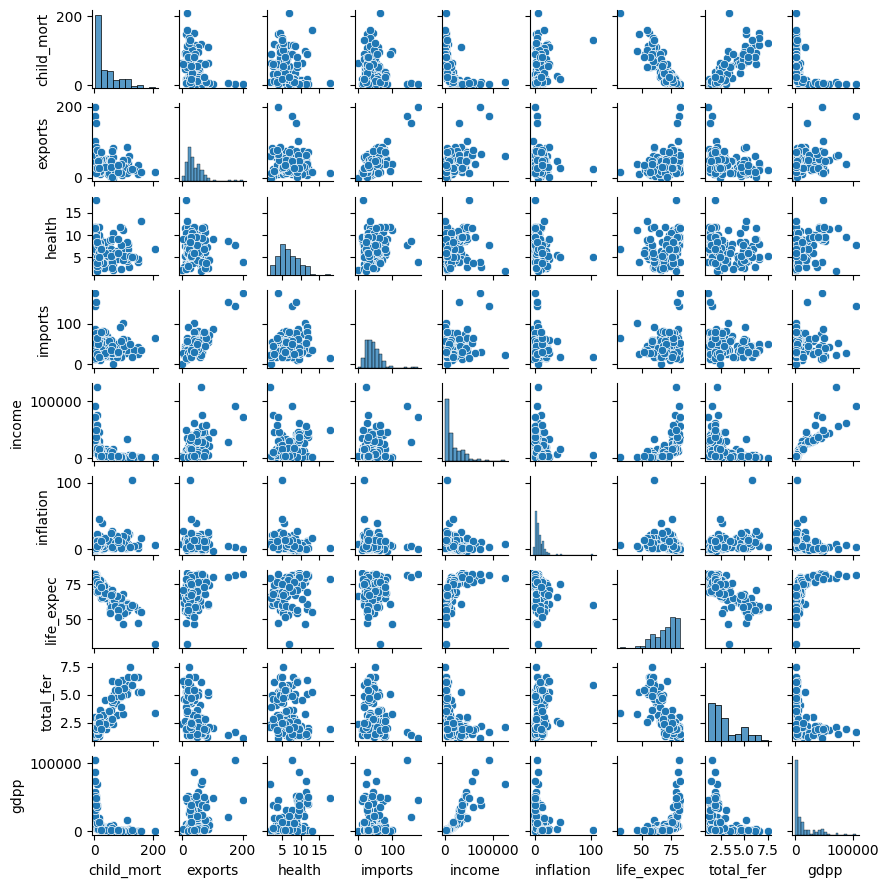

In [6]:
# Plot a pair plot for the quantitative columns
sns.pairplot(df[quantitative_columns], height=1)

# Show the plot
plt.show()

Plotting the variables pairwise we gather the information about the relation between the variables. Some of these relations are not linear and later we will cover this issue.

This is an important step as an observation of the multiple scatterplot showing the pairwise relation between variables in a graphical way.
As can be observed this relation is only measured between quantitative variables, otherwise it won’t make sense because plotting categorical variables generates an output with no analyzable relation.
As we can see we have some linear relations, but most of them are not. We have some inverse relations, logarithmic or square root relation, between others.

Applying theory, some transformations will be done in order to change it into a linear relation to work better.


## 2.3. Intercorrelation coefficients

In [7]:
R = df[quantitative_columns].corr().values  # Calculate correlation matrix

# Calculate the inverse of the correlation matrix
R_inv = np.linalg.inv(R)

# Eigenvalues of the correlation matrix
eigenvalues = np.linalg.eigvals(R)
p = len(eigenvalues)  # Number of variables

# Calculate q1 through q6
q1 = (1 - min(eigenvalues) / max(eigenvalues)) ** (p + 2)
q2 = 1 - (p / np.sum(1 / eigenvalues))
q3 = 1 - np.sqrt(np.linalg.det(R))
q4 = (max(eigenvalues) / p) ** (3/2)
q5 = (1 - min(eigenvalues) / p) ** 5
q6 = np.sum([1 - (1 / R_inv[j, j]) for j in range(p)]) / p

# Print the indices
print(f"q1: {q1}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"q4: {q4}")
print(f"q5: {q5}")
print(f"q6: {q6}")


q1: 0.8531793193726251
q2: 0.8147440628141916
q3: 0.9781634151618707
q4: 0.3220620787669982
q5: 0.9667823787345693
q6: 0.7200370367827341


We have computed 6 different intercorrelation oefficients. 

$$
q_1=\left(1-\frac{min \lambda_j}{max \lambda_j}\right)^{p+2} \quad q_2=1-\frac{p}{\sum_{j=1}^p\frac{1}{\lambda_j}} \quad q_3 = 1 - \sqrt{\textbf{|R|}} \quad q_4=\left(\frac{max \lambda_j}{p}\right)^{\frac{3}{2}} \quad q_5=\left(1-\frac{min \lambda_j}{p}\right)^5 \quad q_6=\sum_{j=1}^p\frac{1-1/r^{jj}}{p}
$$

Where $\lambda_1,...,\lambda_p$ are the eigen values of the correlation matrix ($\textbf{R}$), $r^{jj}$ is the $j-th$ diagonal element of $\textbf{R}^{-1}$ and $|\textbf{R}|$ is the determinant of the matrix. 

Also $q_i \in [0,1] \space \forall \space i$  and the closer to 1 the greater the amount of intercorrelation between variables.


5 of them conclude the same, that exists a high intercorrelation between all the parameters. This indicates that PCA might be a good approach to reduce the dimensionality of the dataset.

## 2.4 Data Visualization

### 2.4.1. Binary variables

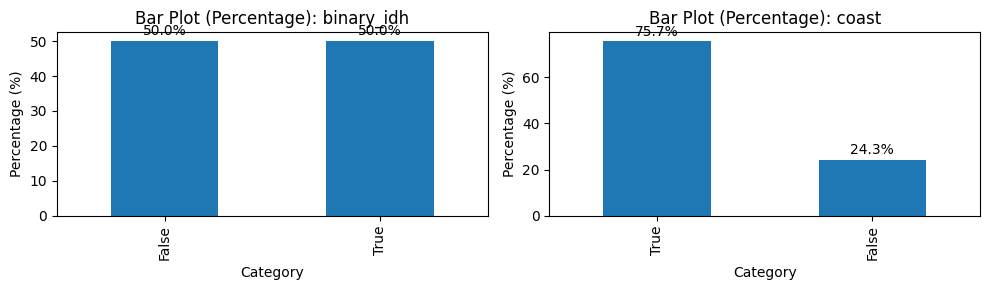

In [8]:
if binary_columns:
    fig, axes = plt.subplots(1, len(binary_columns), figsize=(5 * len(binary_columns), 3))
    for idx, col in enumerate(binary_columns):
        value_counts = df[col].value_counts(normalize=True) * 100  # Calculate percentages
        value_counts.plot(kind='bar', ax=axes[idx] if len(binary_columns) > 1 else axes)
        axes[idx].set_title(f'Bar Plot (Percentage): {col}')
        axes[idx].set_xlabel('Category')
        axes[idx].set_ylabel('Percentage (%)')
        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

1. **`IDH`**: As IDH was a continuous variable that we have manually categorized splitting by the median, it has exactly half of the observation in each class.

2. **`Coast`**: 75.7% of the countries in the data set have coast.  

### 2.4.2. Multiclass variables

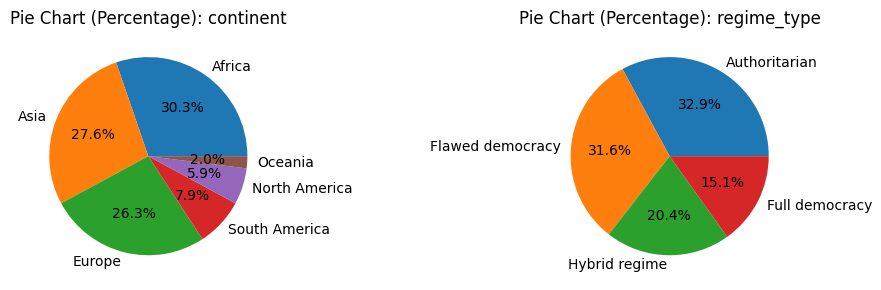

In [9]:
if multiclass_columns:
    fig, axes = plt.subplots(1, len(multiclass_columns), figsize=(5 * len(multiclass_columns), 3))
    for idx, col in enumerate(multiclass_columns):
        value_counts = df[col].value_counts(normalize=True) * 100  # Calculate percentages
        value_counts.plot(kind='pie', ax=axes[idx] if len(multiclass_columns) > 1 else axes, autopct='%1.1f%%')
        axes[idx].set_title(f'Pie Chart (Percentage): {col}')
        axes[idx].set_ylabel('')  # Remove default ylabel
    plt.tight_layout()
    plt.show()

1. **`Continents`**: We can see how the most common continent in the data is Africa, followed by Asia and Europe. And Oceania has a very low representation in the data set.


2. **`Regime Type`**: A curious and bitter fact we've obtained from this pie chart is that Full democracy represents only 15.1% of the countries in the world. 

### 2.4.3. Quantitative variables

To adjust to the number of pages asked we are only plotting a few of them as an example. 

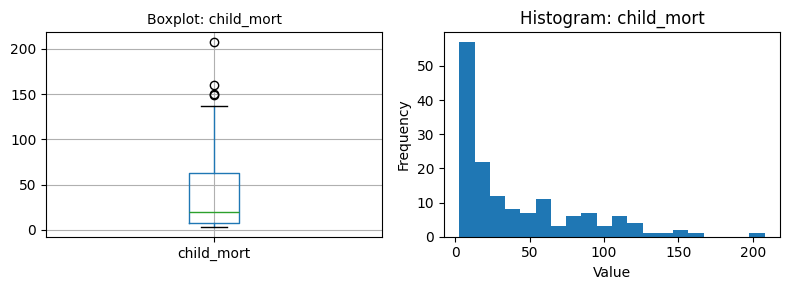

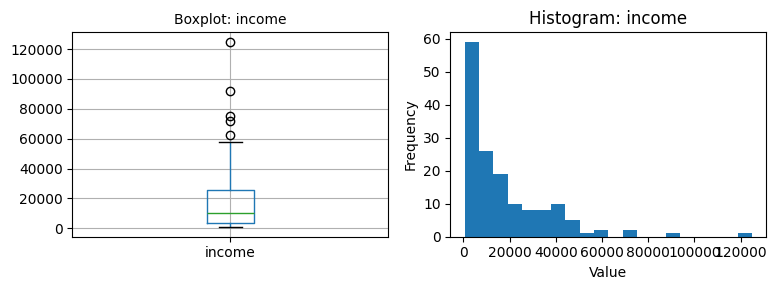

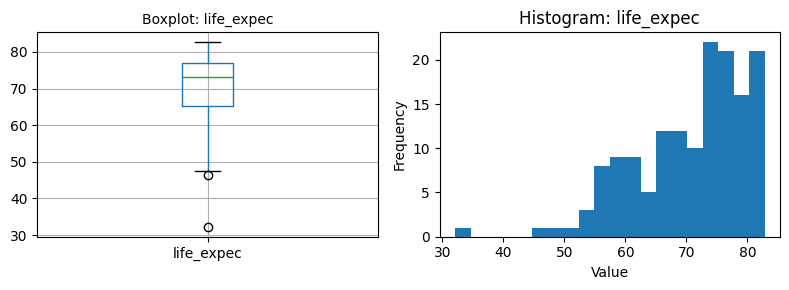

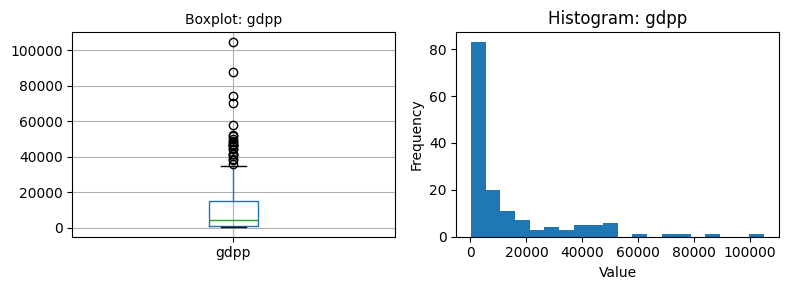

In [10]:
#for col in quantitative_columns:
for col in ['child_mort', 'income', 'life_expec', 'gdpp']:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    # Boxplot
    df.boxplot(column=col, ax=axes[0])
    axes[0].set_title(f'Boxplot: {col}', fontsize=10)
    # Histogram
    df[col].plot(kind='hist', bins=20, ax=axes[1])
    axes[1].set_title(f'Histogram: {col}')
    axes[1].set_xlabel('Value')
    plt.tight_layout()
    plt.show()

Here we have analyzed each of the variables with BoxPlot and Histogram. The first one shows the principal statistics of the distribution with the median (green line), interquartile range (between the first one and the third one) with the box and other values. Those considered outliers are shown as empty points. We are able to see the variability and the values where the observations are around of.

The second one shows the frequency of the different values, how many times a value is repeated in the observations divided in bins. It can be observed the skewness of the distribution, the most repeated values with the mode and an intuition of the median and mean.

The variables have a pattern based on right-skewness except life expectancy (due to the nature of this variable) and health or imports that seems to be more normally distributed.
We have also the observations in the box plot. It shows, for example, that the variable GDP per capita has lots of outliers, being a variable that depends a lot of the economic or welfare level of each country. We can see that the median and most of the variables are situated in the smaller values, showing outliers for rich countries. Meanwhile, the variable health has less outliers but more variability according to its scale. Other ones as total fertility has no outliers due to its nature: there is a limited number of births per a woman life.

In general, there are no excess of outliers (except in GDP per capita) so are good variables to work with and depending on the characteristics of each one the variability and the most frequent values vary.


### 2.5. Data transformation

#### 2.5.1. Skewness correction

## Data Transformations Applied

### **Logarithmic Transformations (`log1p`)**
The logarithmic transformation reduces the skewness of the data by compressing larger values while preserving proportional relationships.

#### Transformed Variables:
- **`child_mort`**: Proportional differences in child mortality are emphasized. For instance, a change from $10$ to $20$ (a $2\times$ increase) has the same impact as a change from $100$ to $200$.
- **`gdpp`**: Focuses on proportional increases in GDP rather than absolute differences. For example, doubling GDP from $1,000$ to $2,000$ contributes equally to the analysis as doubling from $10,000$ to $20,000$.
- **`income`**: Similar to `gdpp`, proportional increases in income are emphasized, and extreme values are less dominant.
- **`total_fer`**: Highlights proportional differences in fertility rates. For instance, a change from $2$ to $4$ ($2\times$ increase) has the same weight as a change from $5$ to $10$.
- **`imports`**: Emphasizes proportional increases in import activity while compressing extreme values.

---

### **Shifted Log Transformation (`inflation`)**
The variable `inflation` includes negative values, requiring a shift before applying the logarithmic transformation. The shift was calculated as:

$$ \text{shift} = |\text{min} \, (\text{inflation})| + 1 $$

The transformation formula is:

$$ \text{inflation_transformed} = \log(\text{inflation} + \text{shift} + 1) $$

#### Effect:
This transformation ensures that the logarithm is defined for all values, including originally negative inflation. It captures proportional differences in inflation while accounting for the applied shift during interpretation.

---

### **Squared Transformation (`life_expec`)**
The variable `life_expec` (life expectancy in years) was squared:

$$ \text{life_expec_transformed} = (\text{life_expec})^2 $$

#### Effect:
This transformation magnifies differences at higher life expectancy levels, making countries with very high life expectancies (e.g., $80+$ years) more prominent in the analysis. Conversely, differences at lower levels (e.g., $50$ to $60$ years) are relatively de-emphasized.

In [11]:
df_trans = df.copy()
df_trans['child_mort'] =  np.log1p(df['child_mort'])
df_trans['gdpp'] =  np.log1p(df['gdpp'])
df_trans['income'] =  np.log1p(df['income'])
df_trans['total_fer'] =  np.log1p(df['total_fer'])
df_trans['imports'] =  np.log1p(df['imports'])

# Shift the data to be positive, log-transform is not defined in negative values. Inflation can be negative.
df_trans['inflation'] = df['inflation']
shift = np.abs(df['inflation'].min()) + 1
df_trans['inflation'] = df_trans['inflation'] + shift
df_trans['inflation'] =  np.log1p(df_trans['inflation'])

df_trans['life_expec'] = np.square(df['life_expec'])

To check if the transformation has worked, we plot the regarded variables: 

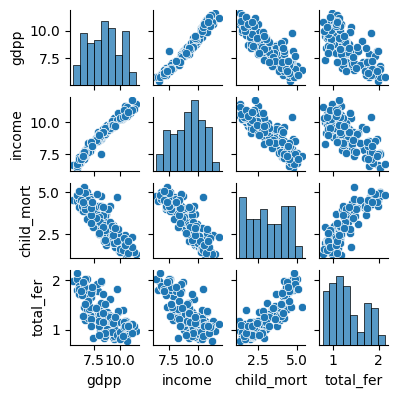

In [12]:
# Plot a pair plot for the quantitative columns
sns.pairplot(df_trans[['gdpp', 'income', 'child_mort', 'total_fer']], height=1)

# Show the plot
plt.show()


After the transformations we can apreciate better linear relation between the variables pairwaise and that the skewness has been reduced.

---

To see the behaviour of the new variables, let's compute the Box plot and histogram of some of the transformed continuous variables:

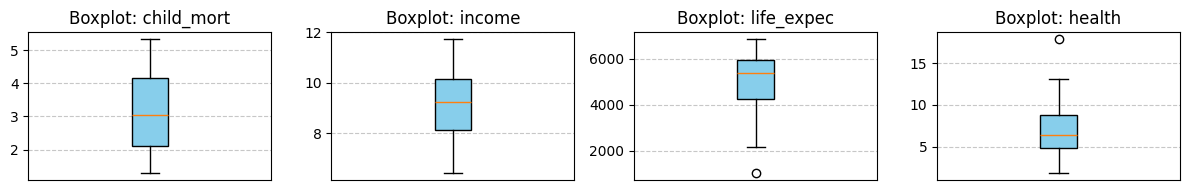

In [13]:
# List of columns to plot
#columns = ['gdpp', 'income', 'total_fer', 'inflation', 'imports', 'child_mort', 'life_expec']
columns = ['child_mort', 'income', 'life_expec', 'health']

# Set up the grid dimensions
n_cols = len(columns)  
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 3, 2)) 
axes = axes.flatten() if len(columns) > 1 else [axes]

# Plot each variable's boxplot
for i, col in enumerate(columns):
    axes[i].boxplot(df_trans[col].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].set_xticks([])  # Remove x-axis labels for individual subplots
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()



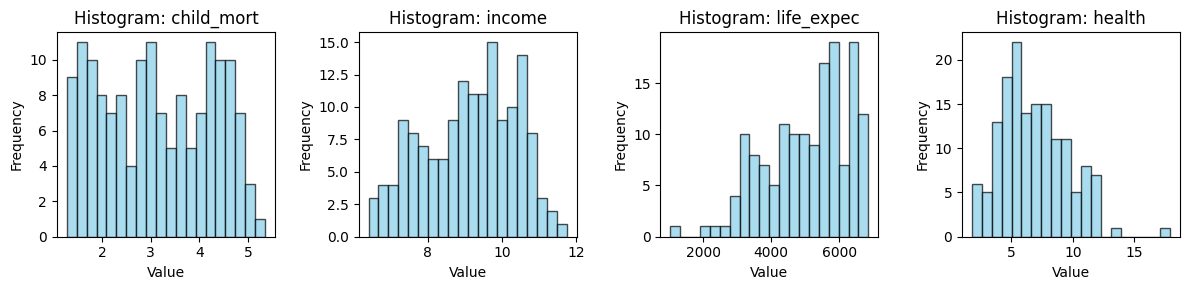

In [14]:
# Number of columns to plot
#columns = ['gdpp', 'income', 'total_fer', 'inflation', 'imports', 'child_mort', 'life_expec']
columns = ['child_mort', 'income', 'life_expec', 'health']

# Set up the grid
n_cols = len(columns)  
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 3, 3)) 
axes = axes.flatten() if len(columns) > 1 else [axes]

# Plot each variable's histogram
for i, col in enumerate(columns):
    axes[i].hist(df_trans[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram: {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### 2.5.2. Standardization

As we are working with variables in different scales, there's no other option than working with the standardized data. We are going to compute the standardization of the quantitative variables and its new main statistical measures.

In [15]:
scaler = StandardScaler()

# Apply standardization to all columns in the dataframe and replace them
df_trans[quantitative_columns] = scaler.fit_transform(df_trans[quantitative_columns])
#display(df_trans.head())
df_trans.describe().loc[['mean', 'std']]

child_mort       exports        health       imports        income  \
mean  8.472755e-17  2.103580e-16  1.577685e-16 -8.706486e-16  8.501971e-16   
std   1.003306e+00  1.003306e+00  1.003306e+00  1.003306e+00  1.003306e+00   

         inflation    life_expec     total_fer          gdpp  
mean  4.148728e-16 -5.156694e-16  4.528541e-16 -1.285521e-15  
std   1.003306e+00  1.003306e+00  1.003306e+00  1.003306e+00

After applying the standardization, we've checked if the variables are centered around zero. And the standard deviation is 1. (Aproximately, small errors can happen due to the floating point arithmetic). 

## 2.6. Principal Component Analysis (PCA)

It is a statistical technique used to reduce the dimensionality of a dataset while preserving as much variance as possible. This is achieved by transforming the original variables into a new set of uncorrelated variables, called **principal components** (PCs), ordered by the amount of variance they explain. The principal components are computed as linear combinations of the original variables.  The eigenvalues represent the variance explained by each principal component. The first eigenvalue corresponds to the principal component that explains the most variability, the second eigenvalue to the second PC and so on. Geometrically speaking the principal components are the directions of maximum variance in the data. The data is projected onto these orthogonal directions, ensuring the projections are uncorrelated.

**Explained Variance**:

   The proportion of variance explained by the $i$-th principal component is given by:
   $$
   \text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^p \lambda_j},
   $$
   where $\lambda_i$ is the eigenvalue corresponding to the $i$-th principal component and $p$ is the total number of components.

**Dimensionality Reduction**:

   To reduce dimensionality, select the top $k$ principal components that capture most of the variance, and transform the original data:
   $$
   Z_{\text{reduced}} = Z V_k
   $$
   where $V_k$ is the matrix of the first $k$ eigenvectors.


In [16]:
pca = PCA()
pca_results = pca.fit_transform(df_trans[quantitative_columns])

pca_df = pd.DataFrame(
    data=pca_results,
    columns=[f"PC{i+1}" for i in range(pca_results.shape[1])]
)

df_trans_pca = pd.concat([df_trans.reset_index(drop=True), pca_df], axis=1)

### 2.6.1. Principal Component Selection

Explained Variance Ratio: [0.55239705 0.16311626 0.13046908 0.06666726 0.04074944 0.02239302
 0.016831   0.00600852 0.00136836]
Eigenvalues: [5.00449779 1.47776853 1.18199803 0.6039789  0.36917378 0.20287185
 0.15248215 0.05443483 0.01239678]
Number of components retained by Kaiser's Criterion: 3
Number of components retained by Jolliffe's Criterion: 3


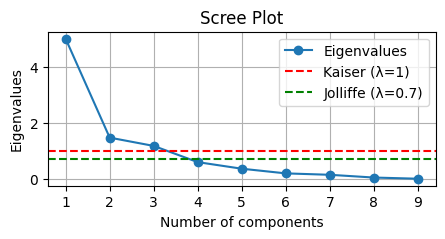

In [17]:
# Print the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum

eigenvalues = pca.explained_variance_

# Kaiser's Criterion: Retain PCs with eigenvalues > 1
kaiser_criteria = eigenvalues > 1
kaiser_retained = np.sum(kaiser_criteria)

# Jolliffe's Criterion: Retain PCs with eigenvalues > 0.7
jolliffe_criteria = eigenvalues > 0.7
jolliffe_retained = np.sum(jolliffe_criteria)

# Percentage of Explained Variability: Retain PCs until cumulative variance >= 90%
threshold = 0.80
percentage_retained = np.argmax(cumulative_variance >= threshold) + 1

# Results
print(f"Eigenvalues: {eigenvalues}")
print(f"Number of components retained by Kaiser's Criterion: {kaiser_retained}")
print(f"Number of components retained by Jolliffe's Criterion: {jolliffe_retained}")

# Gráfico Scree Plot
plt.figure(figsize=(5, 2))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', label='Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--', label='Kaiser (λ=1)')
plt.axhline(y=0.7, color='g', linestyle='--', label='Jolliffe (λ=0.7)')
plt.title("Scree Plot")
plt.xlabel("Number of components")
plt.ylabel("Eigenvalues")
plt.legend()
plt.grid()
plt.show()

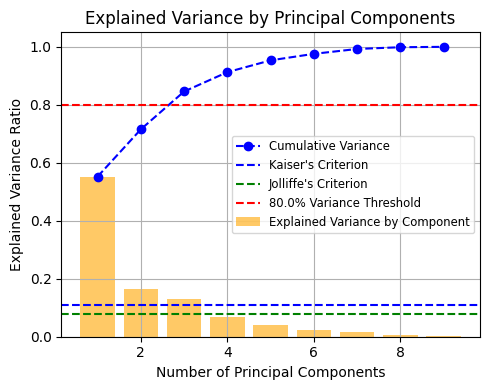

In [18]:
# Total variance is the sum of eigenvalues
total_variance = np.sum(eigenvalues)

# Convert Kaiser and Jolliffe thresholds to the explained variance ratio
kaiser_threshold_ratio = 1 / total_variance
jolliffe_threshold_ratio = 0.7 / total_variance

# Plotting
plt.figure(figsize=(5, 4))

# Line plot for cumulative variance
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    linestyle='--',
    color='b',
    label="Cumulative Variance"
)

# Bar plot for explained variance by component
plt.bar(
    range(1, len(explained_variance) + 1),
    explained_variance,
    alpha=0.6,
    color='orange',
    label="Explained Variance by Component"
)

# Add horizontal lines for thresholds
plt.axhline(y=kaiser_threshold_ratio, color='blue', linestyle='--', label="Kaiser's Criterion")
plt.axhline(y=jolliffe_threshold_ratio, color='green', linestyle='--', label="Jolliffe's Criterion")
plt.axhline(y=threshold, color='red', linestyle='--', label=f'{threshold*100}% Variance Threshold')

# Labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best', fontsize='small')
plt.grid()
plt.tight_layout()

# Show plot
plt.show()

To choose the number of principal components we've used 3 different criteria:

- Cumulative variance: Simply this criteria shows where to cut based on a percentage of explained variability. We took 80% but other high percentage are useful. Notice that with the third component our percentage of explained variability passes the 0.8 barrier so we take 3 components by this criteria.

- Kaiser's Criterion: We exclude the components whose eigenvalues are smaller than $\bar{\lambda}=1$. Again we see that the fourth component is not included so we take 3 components.

- Jolliffe's Criterion: FInally to corroborate if number of variables is $p<20$ we can discard those eigenvalues that are smaller than $\bar{\lambda}=0.7$, and again is the same case.

The 3 of them show the same conclusion, We should select 3 principal components.



### 2.6.2 PC Interpretation

#### PC1 vs. PC2

In [19]:
pc1_loadings = pd.Series(pca.components_[0], index=quantitative_columns)
# Sort by absolute value to find the most influential variables
pc1_sorted = pc1_loadings.sort_values(ascending=False)
print("Variables driving PC1:")
print(pc1_sorted)


Variables driving PC1:
child_mort    0.432985
total_fer     0.392340
inflation     0.234860
imports      -0.098518
health       -0.175862
exports      -0.230285
life_expec   -0.404406
income       -0.414432
gdpp         -0.417698
dtype: float64


In [20]:
pc2_loadings = pd.Series(pca.components_[1], index=quantitative_columns)
pc2_sorted = pc2_loadings.sort_values(ascending=False)
print("Variables driving PC2:")
print(pc2_sorted)

Variables driving PC2:
imports       0.724250
exports       0.622777
total_fer     0.086959
child_mort    0.084141
inflation    -0.052376
income       -0.061712
gdpp         -0.083732
life_expec   -0.155801
health       -0.187435
dtype: float64


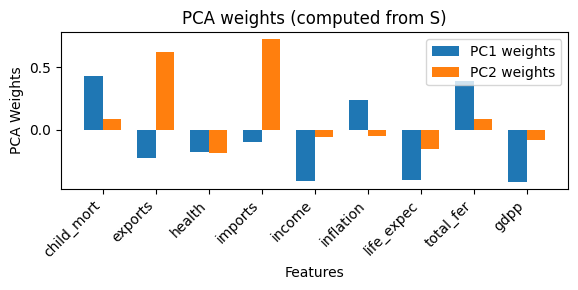

In [21]:
# Extract the PCA loadings
loadings = pca.components_[:2]  # Get the first two principal components
num_features = len(quantitative_columns)

# Create the bar plot
x = np.arange(num_features)  # Indices for variables
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(6, 3))
bars1 = ax.bar(x - width/2, loadings[0], width, label='PC1 weights')
bars2 = ax.bar(x + width/2, loadings[1], width, label='PC2 weights')

# Add labels, title, and legend
ax.set_xlabel('Features')
ax.set_ylabel('PCA Weights')
ax.set_title('PCA weights (computed from S)')
ax.set_xticks(x)
ax.set_xticklabels(quantitative_columns, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

##### **Interpretation of components 1 and 2**

The interpretation of the first two principal components (PC1 and PC2) reflects the transformed variables used in the PCA. These transformations, including logarithmic scaling, shifting, and squaring, significantly influence the relationships and contributions of the variables to the components.


**Principal Component 1 (PC1): Socio-Economic Gradient**

1. **Positive Contributors (Drive Positive PC1 Values)**:
   - **`child_mort` (Log-transformed)**:
     - Reflects proportional differences in child mortality. Countries with very high child mortality rates (e.g., $50 \to 100$ deaths per 1,000 live births) dominate positive PC1 values.
     - The log transformation compresses extreme values, ensuring smaller changes at higher mortality rates are less dominant.
   - **`total_fer` (Log-transformed)**:
     - High fertility rates strongly contribute to positive PC1 values. The transformation emphasizes proportional differences, where countries with $5+$ children per woman are more prominent than those with $2$ or fewer.
   - **`inflation` (Shifted and Log-transformed)**:
     - Proportional increases in inflation dominate the positive end of PC1. Countries experiencing hyperinflation are significant drivers, but the transformation reduces their extreme influence.

2. **Negative Contributors (Drive Negative PC1 Values)**:
   - **`gdpp` (Log-transformed)**:
     - GDP per capita is a strong negative contributor. Proportional increases in GDP (e.g., $10,000 \to 20,000$) have the same influence as smaller proportional increases (e.g., $1,000 \to 2,000$).
   - **`income` (Log-transformed)**:
     - Higher income levels mirror the impact of GDP, emphasizing proportional differences rather than absolute values.
   - **`life_expec` (Squared)**:
     - The squared transformation magnifies high life expectancy values. Countries with life expectancy above $80+$ years dominate the negative side of PC1.

Interpretation of PC1:

PC1 captures a **developmental gradient**, distinguishing countries based on socio-economic indicators:
- Positive PC1 Values:
  - Represent underdeveloped countries with:
    - High child mortality and fertility rates.
    - Economic instability and high inflation.
  - Examples: Countries with limited healthcare, education, and infrastructure.
- Negative PC1 Values:
  - Represent developed countries with:
    - High GDP, income, and life expectancy.
  - Examples: High-income nations with advanced healthcare systems and stable economies.

---

**Principal Component 2 (PC2): Trade and Economic Activity**

Key Variables and Their Contributions

1. **Positive Contributors (Drive Positive PC2 Values)**:
   - **`imports` (Log-transformed)**:
     - High levels of imports (as a percentage of GDP) dominate positive PC2 values. Proportional increases are emphasized, with trade-oriented countries contributing more.
   - **`exports` (Log-transformed)**:
     - Similar to imports, countries with high export-to-GDP ratios strongly influence positive PC2 values.

2. **Negative Contributors (Drive Negative PC2 Values)**:
   - **`health`**:
     - Lower health expenditure pulls PC2 values into the negative range. Differences in health spending are less dominant than trade variables.
   - **`life_expec` (Squared)**:
     - Countries with shorter life expectancies contribute negatively. The squared transformation de-emphasizes smaller differences at lower life expectancy levels.

Interpretation of PC2:

PC2 reflects **trade openness and economic activity**, distinguishing countries based on their engagement in global trade:
- Positive PC2 Values:
  - Represent trade-oriented economies with:
    - High import and export activity relative to GDP.
    - A strong focus on international trade and globalization.
  - Examples: Economies driven by exports and global trade hubs.
- Negative PC2 Values:
  - Represent countries with lower trade engagement and:
    - Limited import/export activity.
    - Potentially lower investment in healthcare and shorter life expectancy.
  - Examples: Economies that are more self-reliant or less integrated into global trade networks.

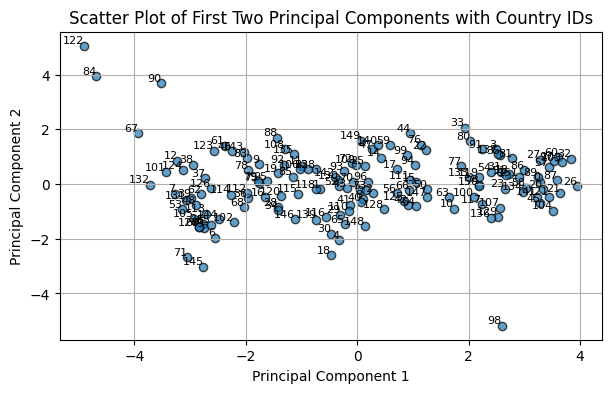

In [22]:
plt.figure(figsize=(7, 4))

# Scatter plot
plt.scatter(df_trans_pca['PC1'], df_trans_pca['PC2'], alpha=0.7, edgecolor='k')

# Adding ID numbers
for i, country_id in enumerate(df_trans_pca.index):  # Assuming index can act as ID
    plt.text(
        df_trans_pca['PC1'][i],
        df_trans_pca['PC2'][i],
        str(country_id),  # Convert index to string
        fontsize=8,
        ha='right',
        va='bottom'
    )

# Titles and labels
plt.title('Scatter Plot of First Two Principal Components with Country IDs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


We can divide the graphic in four:
- Bottom-left quadrant ($PC1<0,PC2<0$): countries with better socieconomic situation, but not open economies.
- Top-left ($PC1<0, PC2>0$): countries with better socieconomic situation and open economies.
- Top-right ($PC1>0,PC2>0$): countries with worse socioeconomic conditions and open economies.
- Bottom-right ($PC1>0,PC2<0$): countries with worse socioeconomic conditions and closed economies.

Notice that since most of the points are spread widely along PC1 (socioeconomic) values showing its dominance. PC2 has a complementary role here showing the aperture level of these economies. It seems that countries $122$, $84$ and $98$ can be outliers, and other countries as $145$, $90$ and $67$ arcan be extreme values.

#### Scatter plots by cluster for PC1 vs PC2

##### SC by Continent

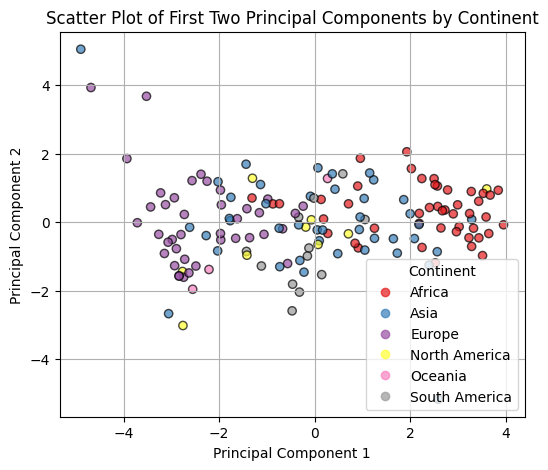

In [23]:
# Scatter plot using the 'continent' column to color the points
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    df_trans_pca['PC1'],
    df_trans_pca['PC2'],
    c=pd.Categorical(df_trans_pca['continent']).codes,
    cmap='Set1',  
    alpha=0.7,
    edgecolor='k'
)

# Adding a legend
legend_labels = list(pd.Categorical(df_trans_pca['continent']).categories)
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Continent')


# Plot titles and labels
plt.title('Scatter Plot of First Two Principal Components by Continent')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

##### SC by Regime

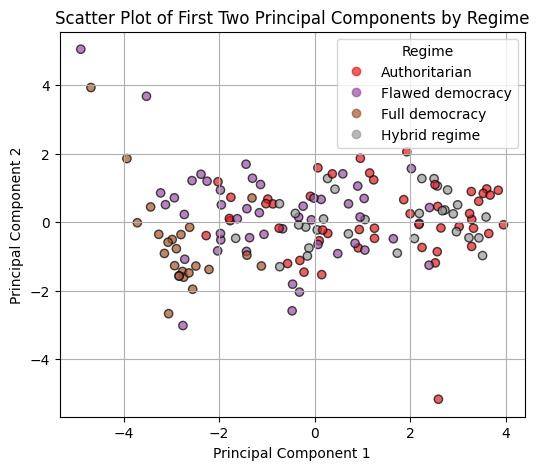

In [24]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    df_trans_pca['PC1'],
    df_trans_pca['PC2'],
    c=pd.Categorical(df_trans_pca['regime_type']).codes,
    cmap='Set1',  
    alpha=0.7,
    edgecolor='k'
)


legend_labels = list(pd.Categorical(df_trans_pca['regime_type']).categories)
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Regime')


plt.title('Scatter Plot of First Two Principal Components by Regime')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


##### SC by Coast

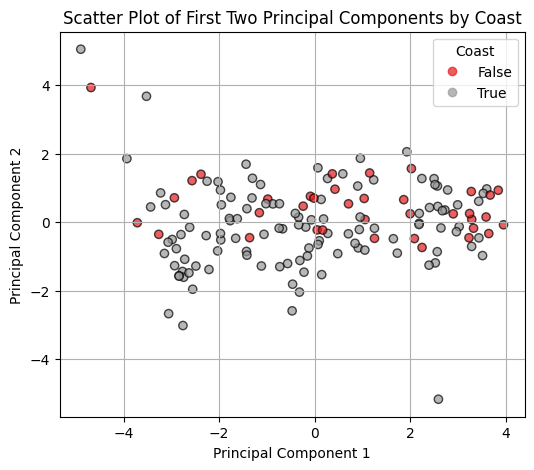

In [25]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    df_trans_pca['PC1'],
    df_trans_pca['PC2'],
    c=pd.Categorical(df_trans_pca['coast']).codes,
    cmap='Set1',  
    alpha=0.7,
    edgecolor='k'
)

legend_labels = list(pd.Categorical(df_trans_pca['coast']).categories)
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Coast')

plt.title('Scatter Plot of First Two Principal Components by Coast')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


##### SC by IDH

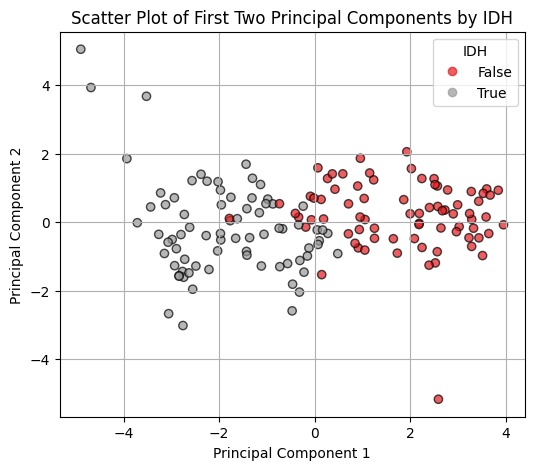

In [26]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    df_trans_pca['PC1'],
    df_trans_pca['PC2'],
    c=pd.Categorical(df_trans_pca['binary_idh']).codes,
    cmap='Set1',  
    alpha=0.7,
    edgecolor='k'
)

# Adding a legend
legend_labels = list(pd.Categorical(df_trans_pca['binary_idh']).categories)
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='IDH')

# Plot titles and labels
plt.title('Scatter Plot of First Two Principal Components by IDH')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

Let's comment quickly some patterns that we can see here:

-	**By continents:** There are not very definite clusters, but we can see some patterns:  

    - Most of the European countries are in the left part (negative PC1) with two from North America (probably USA and Canada)

    - Most of the African countries are in the right part, showing worse socioeconomic indicators. 

    - Asia has more diversity and more complex structure in this sense. There exists more variability and there are countries with very good indicators (let’s say Singapore as an extreme) and others with very bad ones, (let’s say Myanmar as another extreme).

    - Again, as we have explained before, the relation is more related with PC1, so clusters are distributed along a horizontal path. It shows that the open/closed economies (PC2) is not a variable with capacity to cluster, having all continents countries with high and low level of commerce (imports and exports).

-	**By type of Regime:** Again, we are not able to see any specific cluster, but we see a pattern:

    - Full democracy countries are all of them in the left part, with best socioeconomic position by PC1.

    - Authoritarian regimes are distributed along the graphic, but with some cluster in the rightmost part of it.

-	**By the condition of having Coast or not:**

When we add this variable, we were thinking that the access to sea was a condition for relations and development (both PC1 and PC2), but as is shown, there is no a specific pattern. Can be intuited that even for commerce (ports as an important point for international transactions) there is no positive relation between having coast and commerce, because most of the red points (no coast) are situated in the upper part of the graphic (more commerce).

-	**By being over the median of IDH or not:**

Finally, we find clusters. It is obvious since the Human Development Index is calculated with socioeconomic indicators. Of course, those countries with less IDH are situated in the right part with worse PC1, and those with highest (over the median) IDH are in the left part. Notice that if we had decided to stablish other criteria (developed countries are over the $3^{rd}$ quartile) the division would be further to the left.



#### PC1 vs. PC3

In [27]:
pc3_loadings = pd.Series(pca.components_[2], index=quantitative_columns)
pc3_sorted = pc3_loadings.sort_values(ascending=False)

print("Variables driving PC3:")
print(pc3_sorted)

Variables driving PC3:
health        0.682311
imports       0.263983
total_fer     0.040081
child_mort   -0.003947
life_expec   -0.096876
gdpp         -0.154944
exports      -0.224470
income       -0.259575
inflation    -0.558556
dtype: float64


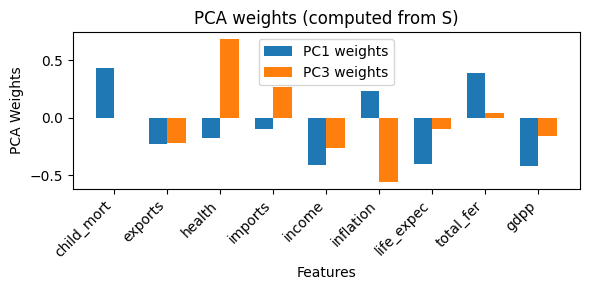

In [28]:
# Extract the PCA loadings
loadings = pca.components_[0:3]  
num_features = len(quantitative_columns)

# Create the bar plot
x = np.arange(num_features)  # Indices for variables
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(6, 3))
bars1 = ax.bar(x - width/2, loadings[0], width, label='PC1 weights')
bars2 = ax.bar(x + width/2, loadings[2], width, label='PC3 weights')

# Add labels, title, and legend
ax.set_xlabel('Features')
ax.set_ylabel('PCA Weights')
ax.set_title('PCA weights (computed from S)')
ax.set_xticks(x)
ax.set_xticklabels(quantitative_columns, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

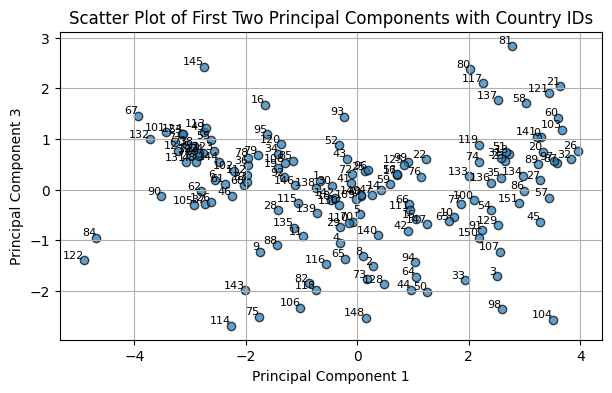

In [29]:
plt.figure(figsize=(7, 4))

# Scatter plot
plt.scatter(df_trans_pca['PC1'], df_trans_pca['PC3'], alpha=0.7, edgecolor='k')

# Adding ID numbers
for i, country_id in enumerate(df_trans_pca.index):  # Assuming index can act as ID
    plt.text(
        df_trans_pca['PC1'][i],
        df_trans_pca['PC3'][i],
        str(country_id),  # Convert index to string
        fontsize=8,
        ha='right',
        va='bottom'
    )

# Titles and labels
plt.title('Scatter Plot of First Two Principal Components with Country IDs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.grid()
plt.show()

#### PC2 vs. PC3

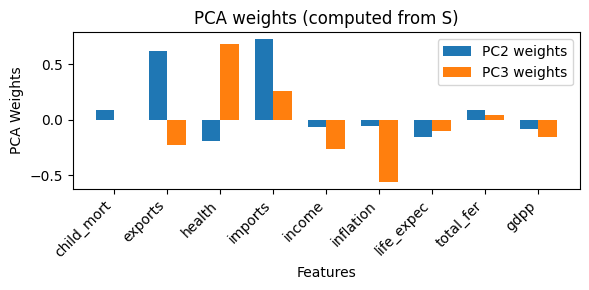

In [30]:
# Extract the PCA loadings
loadings = pca.components_[0:3]  
num_features = len(quantitative_columns)

# Create the bar plot
x = np.arange(num_features)  # Indices for variables
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(6, 3))
bars1 = ax.bar(x - width/2, loadings[1], width, label='PC2 weights')
bars2 = ax.bar(x + width/2, loadings[2], width, label='PC3 weights')

# Add labels, title, and legend
ax.set_xlabel('Features')
ax.set_ylabel('PCA Weights')
ax.set_title('PCA weights (computed from S)')
ax.set_xticks(x)
ax.set_xticklabels(quantitative_columns, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

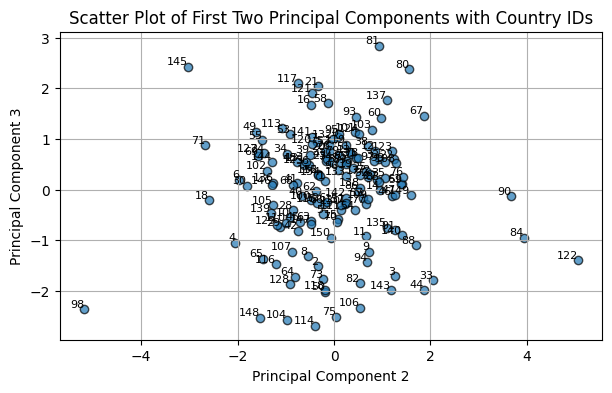

In [31]:
plt.figure(figsize=(7, 4))

# Scatter plot
plt.scatter(df_trans_pca['PC2'], df_trans_pca['PC3'], alpha=0.7, edgecolor='k')

# Adding ID numbers
for i, country_id in enumerate(df_trans_pca.index):  # Assuming index can act as ID
    plt.text(
        df_trans_pca['PC2'][i],
        df_trans_pca['PC3'][i],
        str(country_id),  # Convert index to string
        fontsize=8,
        ha='right',
        va='bottom'
    )

# Titles and labels
plt.title('Scatter Plot of First Two Principal Components with Country IDs')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.grid()
plt.show()

To avoid overextending the project and surpassing the page limit, we are going to omit the interpretation of the remaining PC pairs.

### 2.6.3. PCA STABILITY

#### Leave-One-Out Analysis

### **Purpose of the Analysis**
The purpose of the Leave-One-Out Analysis (LOO) is to assess the **stability** of the PCA configuration by iteratively removing one observation at a time. This allows us to evaluate the influence of individual observations on the PCA results and identify observations with disproportionate effects on the configuration.

---

### **Code Breakdown**

#### **Step 1: Initialization**
- The input data (`X_scaled`) is a scaled version of the dataset.
- The original PCA-transformed data is stored in `Y_original`.
- An empty array `Y_augmented` is initialized to store the PCA configurations after the Leave-One-Out analysis.

#### **Step 2: Leave-One-Out Process**
For each observation (indexed by $i$):
1. **Exclusion**: The $i$-th observation is excluded from the dataset (`X_leave_one_out`).
2. **Recompute PCA**:
   - PCA is recomputed on the reduced dataset (`pca_loo`).
   - The eigenvectors of the reduced dataset are stored as `T_loo`.
3. **Projection**:
   - The excluded observation ($x_i$) is projected onto the new PCA configuration using:
     $$ y_i = x_i \cdot T_{\text{loo}} $$
   - The new configuration, augmented with the projected observation, is stored in `Y_augmented`.

#### **Step 3: Euclidean Distance Calculation**
The **Euclidean distance** is calculated for each observation to quantify the impact of its exclusion:
$$ \text{distance}_i = \| Y_{\text{original},i} - Y_{\text{augmented},i} \| $$

#### **Step 4: Threshold and Significant Observations**
- A threshold is calculated to identify significant observations:
  $$ \text{Threshold} = \text{mean}(\text{distances}) + 2 \times \text{std}(\text{distances}) $$
- Observations with distances greater than this threshold are considered **significant** and have a notable influence on the PCA configuration.

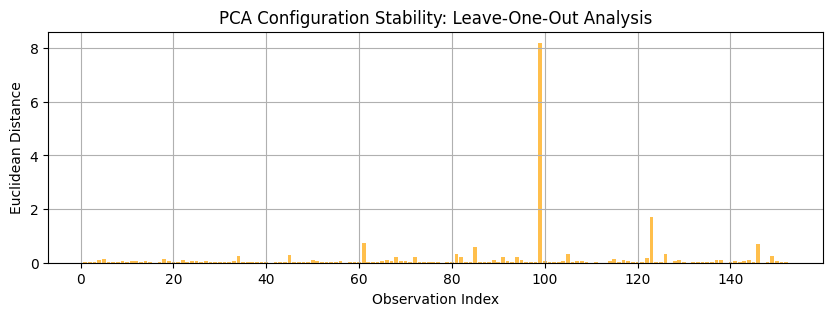

Threshold for significant distances: 1.4888752720735605
Number of significant observations: 2
Rows with significant influence on PCA configuration:


country  child_mort   exports    health   imports    income  inflation  \
98     Myanmar    0.923921 -1.472199 -1.781091 -6.699544 -0.724386   0.150709   
122  Singapore   -1.603068  5.734681 -1.051036  2.666238  1.658857  -1.364502   

     life_expec  total_fer      gdpp       regime_type continent  coast  \
98    -0.490398  -0.222231 -1.029555     Authoritarian      Asia   True   
122    1.466602  -1.494806  1.477281  Flawed democracy      Asia   True   

     binary_idh  
98        False  
122        True

In [32]:
def leave_one_out(df, pca, plot=True):
    X_scaled = df.to_numpy()
    Y_original = pca.transform(df)
    # Initialize an array to store augmented configurations
    n, p = X_scaled.shape
    Y_augmented = np.zeros_like(Y_original)

    # Step 2: Perform Leave-One-Out PCA
    for i in range(n):
        # Exclude the i-th observation
        X_leave_one_out = np.delete(X_scaled, i, axis=0)
        
        # Compute PCA on the reduced dataset
        pca_loo = PCA()
        Y_loo = pca_loo.fit_transform(X_leave_one_out)
        T_loo = pca_loo.components_.T  # Eigenvectors of the reduced dataset
        
        # Project the excluded observation onto the new configuration
        x_i = X_scaled[i, :].reshape(1, -1)  # Row vector of the excluded observation
        y_i = np.dot(x_i, T_loo)  # Projection
        
        # Augment the PCA configuration with the projected observation
        Y_augmented[i, :] = np.insert(Y_loo, i, y_i, axis=0)[i, :]  # Add y_i to Y_loo

    # Step 3: Compute Euclidean distances
    euclidean_distances = np.linalg.norm(Y_original - Y_augmented, axis=1)

    # Results
    #print("Original PCA Configuration (Y):", Y_original)
    #print("Augmented PCA Configuration (Y*):", Y_augmented)
    #print("Euclidean Distances between Y and Y*: ", euclidean_distances)
    if plot:
        plt.figure(figsize=(10, 3))
        plt.bar(range(1, n + 1), euclidean_distances, color='orange', alpha=0.7)
        plt.xlabel('Observation Index')
        plt.ylabel('Euclidean Distance')
        plt.title('PCA Configuration Stability: Leave-One-Out Analysis')
        plt.grid()
        plt.show()
    
    # Compute the threshold: mean + 2 * standard deviation
    threshold = np.mean(euclidean_distances) + 2 * np.std(euclidean_distances)

    # Find indices of rows with distances above the threshold
    significant_indices = np.where(euclidean_distances > threshold)[0]

    # Print the threshold
    print(f"Threshold for significant distances: {threshold}")
    print(f"Number of significant observations: {len(significant_indices)}")

    # Print the significant rows
    return significant_indices

significant_indices = leave_one_out(df_trans[quantitative_columns], pca)
print("Rows with significant influence on PCA configuration:")
# Extract the rows from df that correspond to significant indices
significant_rows = df_trans.iloc[significant_indices]
display(significant_rows)

#### **Bar Plot Analysis**
The bar plot displays the Euclidean distances for all observations and peaks in the plot represent observations with the highest influence on the PCA.

- **X-axis**: Observation index.
- **Y-axis**: Euclidean distance between the original and leave-one-out PCA configurations.


#### **Threshold and Significant Observations**
The **threshold** for significant distances is $1.4889$. The **Two observations** that were identified as significant  are **98**: Myanmar and **122**: Singapore.

In [33]:
significant_rows = df.iloc[significant_indices]
display(significant_rows)

country  child_mort  exports  health   imports  income  inflation  \
98     Myanmar        64.4    0.109    1.97    0.0659    3720      7.040   
122  Singapore         2.8  200.000    3.96  174.0000   72100     -0.046   

     life_expec  total_fer   gdpp       regime_type continent  coast  \
98         66.8       2.41    988     Authoritarian      Asia   True   
122        82.7       1.15  46600  Flawed democracy      Asia   True   

     binary_idh  
98        False  
122        True

### Analysis of Influential Observations

#### Observation 98: Myanmar
Myanmar stands out as a significant observation in the PCA configuration due to its extreme characteristics. It exhibits high negative values for variables such as `exports`, `health`, `imports`, and `gdpp`, indicating poor trade performance, low health expenditures, and weak GDP. Additionally, Myanmar shows a small positive value for `inflation`, reflecting a relatively modest level of economic instability. These characteristics highlight Myanmar as an economically underdeveloped country with a high dependency on imports and low levels of economic output. Its unique position in the dataset explains its significant influence on the PCA results.

#### Observation 122: Singapore
Singapore, in contrast, represents the opposite end of the economic spectrum. It has high positive values for `exports` and `income`, emphasizing its status as a global trade hub and one of the most developed economies in the world. On the other hand, Singapore exhibits negative values for `health` and `total_fer`, reflecting its lower fertility rates and a healthcare expenditure pattern that might differ due to its advanced socioeconomic position. As a highly developed, trade-oriented economy, Singapore’s influence on the PCA arises from its distinct reliance on exports and its robust GDP, which are critical to shaping the overall principal components.


The significant influence of Myanmar and Singapore on the PCA configuration can be attributed to their roles as outliers or extreme observations. Myanmar represents an underdeveloped, resource-constrained economy, while Singapore exemplifies a developed, export-driven economy with a high GDP. Their exclusion during the leave-one-out process leads to substantial changes in the PCA configuration, underscoring their importance in shaping the principal components. This analysis highlights how such extreme observations can affect the stability and interpretation of PCA results.

In [34]:
df.describe()[['exports', 'imports']].loc[['min', 'max']]

exports   imports
min    0.109    0.0659
max  200.000  174.0000

It isn't a coincidence that these two countries stand out from the rest. As we can appreciate in the table above they represnt the maximum and minimum values in exports and imports. 

# 3. References

https://www.kaggle.com/code/tanmay111999/clustering-pca-k-means-dbscan-hierarchical/input

https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index#List

https://en.wikipedia.org/wiki/The_Economist_Democracy_Index#List_by_country